In [1]:
!nvidia-smi

Thu Aug 24 20:23:40 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    633MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   30C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import pickle as pk
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


In [ ]:
# Reloading
importlib.reload(ext)
importlib.reload(utils)
importlib.reload(metrics)
importlib.reload(visuals)
print("All Done")

In [4]:
%%time
modelpath   = "data/models/UNIF-10N-25T-200E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-200E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)

if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")   

CPU times: user 1.66 s, sys: 32 ms, total: 1.7 s
Wall time: 1.7 s


In [5]:
%%time
train = utils.list_of_groups(train_frame, group="event_id")
test  = utils.list_of_groups(test_frame,  group="event_id")
train = [event for event in train if len(pd.unique(event["cluster_id"])) ]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))

Train is list of 4800 events.
Test is list of 3600 events.
CPU times: user 2 s, sys: 16 ms, total: 2.02 s
Wall time: 2.01 s


In [6]:
order = ["phi", "r", "z"]

Train 2413
Number of Hits: 68
Number of Tracks: 9


<IPython.core.display.Javascript object>


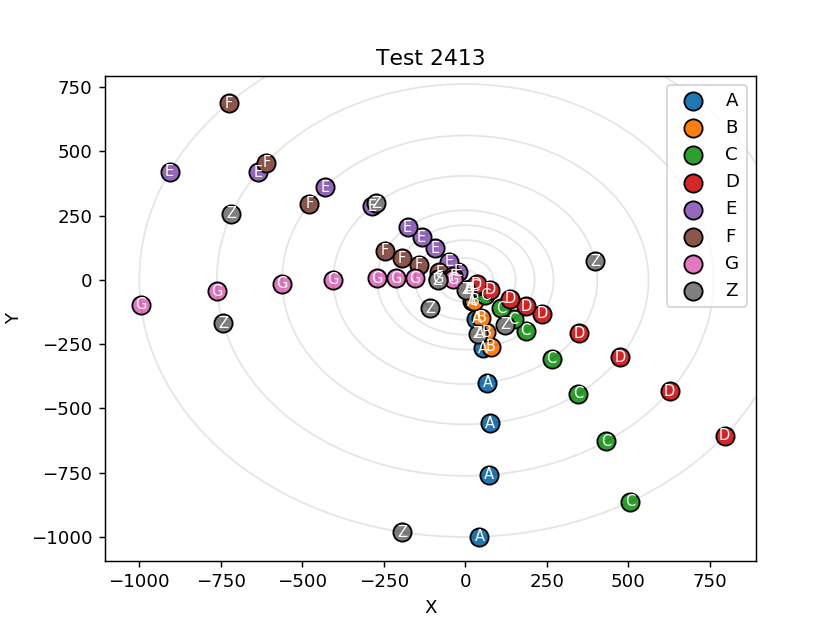

In [7]:
n = np.random.randint(len(test))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(test[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(test[n])))
visuals.Plot2D(test[n], order).plot(mode="xy", title="Test {}".format(n))

In [8]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.119463,213.0,-131.845736,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.708237,39.0,-4.709638,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.664765,85.0,-10.264595,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.620838,1000.0,150.933711,,1,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.590323,155.0,-18.717791,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.530526,213.0,-25.721868,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.518758,762.0,115.011488,,1,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.468557,271.0,-32.725945,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.435408,562.0,84.824745,,1,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.369450,405.0,61.128153,,1,,,,,,,,,,,,,,,,,,,,,,,,,


In [9]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [10]:
model = Sequential()
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=2/5))
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=2/5))
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=2/5))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 235, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 235, 27)           6939      
Total para

In [ ]:
model = keras.models.load_model(modelpath)

In [12]:
%%time
# 32 + 32 + 64
epochs     = 16
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,)]))

Epoch 1/16
48/48 [==============================] - 90s - loss: 0.8586 - acc: 0.6756 - val_loss: 1.1612 - val_acc: 0.7352
Epoch 2/16
48/48 [==============================] - 86s - loss: 0.8500 - acc: 0.6784 - val_loss: 1.1498 - val_acc: 0.7315
Epoch 3/16
48/48 [==============================] - 86s - loss: 0.8534 - acc: 0.6797 - val_loss: 1.1510 - val_acc: 0.7348
Epoch 4/16
48/48 [==============================] - 86s - loss: 0.8369 - acc: 0.6825 - val_loss: 1.0900 - val_acc: 0.7370
Epoch 5/16
48/48 [==============================] - 86s - loss: 0.8237 - acc: 0.6883 - val_loss: 1.0643 - val_acc: 0.7372
Epoch 6/16
48/48 [==============================] - 86s - loss: 0.8199 - acc: 0.6886 - val_loss: 0.9922 - val_acc: 0.7389
Epoch 7/16
48/48 [==============================] - 86s - loss: 0.7958 - acc: 0.6966 - val_loss: 1.0810 - val_acc: 0.7361
Epoch 8/16
48/48 [==============================] - 86s - loss: 0.7939 - acc: 0.6981 - val_loss: 1.1241 - val_acc: 0.7359
Epoch 9/16
48/48 [======

In [ ]:
%%time
guesses          = model.predict(test_input)
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

In [ ]:
n = 4
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy")
d = visuals.Plot2D(test[n], order).plot(mode="xy")

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")